# PA4.1 GANs and Latent space interpolation (35 marks)

 This part of the assignment involves implementing a Generative Adversarial Network (GAN) to work with the MNIST dataset, which is readily available in the torchvision package. You'll be tasked with training your GAN to generate images that resemble the handwritten digits from MNIST.

After your GAN is trained and able to generate images, the next step is to explore latent space interpolation between two images. This means you'll learn how to transition smoothly from one digit to another by navigating through the GAN's latent space, a technique that demonstrates the model's ability to understand and manipulate the underlying features of the digits.

Once thats done you will be asked to generate a few images of your own, and then do some mathematical operations with them in the latent space and see what sort of output you can come up with. sounds simple enough right?

[All code blocks should already have been run and the outputs should be visible in order to be graded]

Roll number:

# Imports

Do not include extra imports, you should be able to complete this assignment with the following imports only.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# MNIST dataset loading (3 marks)

Lets start by actually loading the mnist dataset and visualizing some of the images, dont foget to transform the images to the right size and tensor :) and normalize them.

100%|██████████| 9912422/9912422 [00:00<00:00, 434655953.29it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33361524.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 249788398.77it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5401340.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



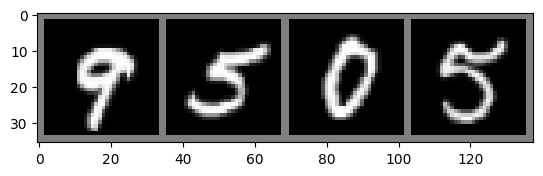

    9     5     0     5


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(4)))


# Generator and Discriminator (10 marks)

Next lets set up the main charecters of our GAN, the generator and the discriminator. Starting of with the generator, feel free to use, whatever sort of architecture you feel suits you, just make sure to use the right activation functions and normalization layers, and that both the generator and the discriminator are able to work with the right size of images.

Feel free to reshape the tensor before passing it through the model, u may explicitly need to do this in atleast one of the models.

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img


In [30]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        validity = self.model(x)
        return validity


In [31]:

latent_dim = 100
img_shape = (32, 32)

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)


# Loss and optimizers

Just like that, were done with the models, now lets set up the loss function and the optimizers for both the models.
For the the timme being do not change them, the given models are pretty standard, and conventional for image gen via GANs.

Other parameters however, you can change, and experiment with, such as the Epochs for example, feel free to experiment with these, and see what works best for you.

In [32]:
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop (5 marks)

Now we have to load the data (preprocess it or do some image augmentation if you need) and train the model.

Lets have brief look at how the loop for a vanilla GAN looks like, and then you can implement it yourself.

Each epoch involves a couple of steps:
1. Prep some data both fake and real
2. Train the discriminator with some real data
3. Train the discriminator with some fake data
3. Train the generator

The rest of its pretty similar to pytorch training loops, similar to the ones youve done in previous assingments.

In [7]:
epochs = 10
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for i, (imgs, _) in enumerate(train_loader):

        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        ############################
        # Train Discriminator
        ############################

        optimizer_d.zero_grad()

        real_imgs = imgs.type(torch.FloatTensor)
        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()

        ############################
        # Train Generator
        ############################

        optimizer_g.zero_grad()

        gen_imgs = generator(z)

        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, epochs, avg_d_loss, avg_g_loss)
    )


[Epoch 1/10] [D loss: 0.328658] [G loss: 3.530894]
[Epoch 2/10] [D loss: 0.520555] [G loss: 1.386118]
[Epoch 3/10] [D loss: 0.475806] [G loss: 1.484785]
[Epoch 4/10] [D loss: 0.477814] [G loss: 1.486489]
[Epoch 5/10] [D loss: 0.469326] [G loss: 1.525191]
[Epoch 6/10] [D loss: 0.471275] [G loss: 1.526351]
[Epoch 7/10] [D loss: 0.475021] [G loss: 1.513477]
[Epoch 8/10] [D loss: 0.473654] [G loss: 1.514562]
[Epoch 9/10] [D loss: 0.470421] [G loss: 1.531092]
[Epoch 10/10] [D loss: 0.464699] [G loss: 1.562194]


# Display images (2 marks)

Just display an image here using your generator model

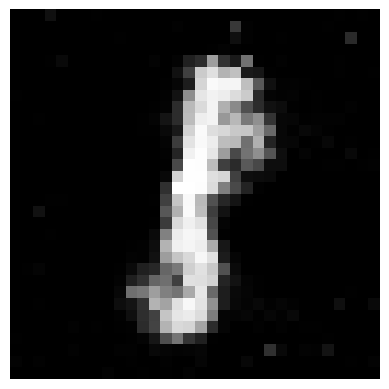

In [8]:
generator.eval()

z = torch.randn(1, latent_dim)

with torch.no_grad():
    generated_img = generator(z)

generated_img_np = generated_img.squeeze().cpu().numpy()

generated_img_np = (generated_img_np + 1) / 2

plt.imshow(generated_img_np, cmap='gray')
plt.axis('off')
plt.show()


# Setting up latent space interpolation  


Alright then, now that we are done with generating images, next lets take a look at the models latent space.

What is it, and how do we use it?

The latent space is the space of all possible inputs that the generator can take, and it is a vector space, and since it is a vector space we can do some vector operations on it, such as interpolation, which is what we will be doing here.

To read up more on this, you can visit the following link: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/ this is a pretty good article on the topic, which also talks about an implementation of this, we will be doing something similar here.

So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation.

# Latent space time (5 marks)


Now that we have the images, lets interpolate between them, So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation, the result here should be a series of images that show how the generator is transitioning from one image to another, how it goes from an image of 3 it generated to an image of 7 for example.

Please make sure that there are atleast 10 steps including, the final and starting images.

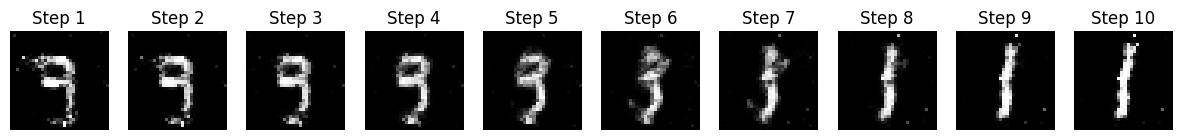

In [9]:
import numpy as np

z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

num_steps = 10

interpolated_images = []
with torch.no_grad():
    for alpha in np.linspace(0, 1, num_steps):
        z_interp = alpha * z1 + (1 - alpha) * z2
        generated_img = generator(z_interp)
        interpolated_images.append(generated_img.squeeze().cpu().numpy())

interpolated_images = [(img + 1) / 2 for img in interpolated_images]

plt.figure(figsize=(15, 3))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Step {}'.format(i+1))
plt.show()


# Vector arithmatic in the latent space (5 marks)

Ok, so if you were able to do that last part, one thing you may have noticed is that, in certain cases  when transitioning between one number and another, the image takes the form of some completely different number, for example, when transitioning from a 3 to a 6, the image may look like a 5 at some point, before going to a 6.

When we interpolate in this latent space, we're essentially taking a path from the representation of one digit to another. However, because this space is learned from the data and is designed to capture the underlying variations within it, the path between any two points can pass through regions that represent a mix of features from both endpoints.

This is equivalent to doing arithmetic in the latent space, and it's a powerful tool for manipulating the representations of the data. For example, if we take the representation of the number 1 and add the representation of the number 0, we can obtain a new representation that captures the shared features of both numbers. something that resembles the circular shape of the 0, but also the vertical line segment of the one so a 9.

That is exactly what you have to do, this is what you have to do:

1. Generate 2 images
2. Perform additon on the latent space vectors of the images
3. Display the results.

do this with atleast 3 different pairs of images.

[(note this addition and subtraction is methaphorical, you are not actually adding or subtracting the vectors, interpolate between them and find a point where features of both images are visible, essentially adding the two images)]

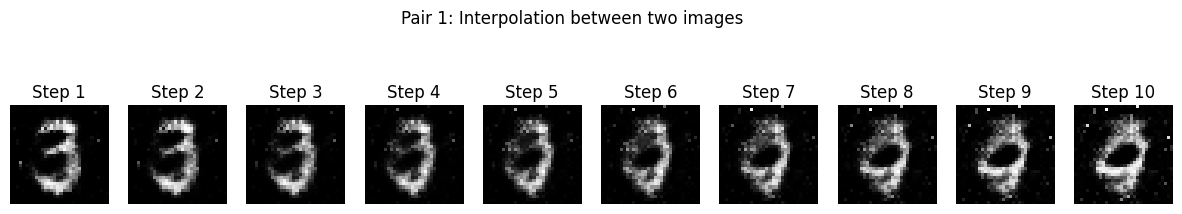

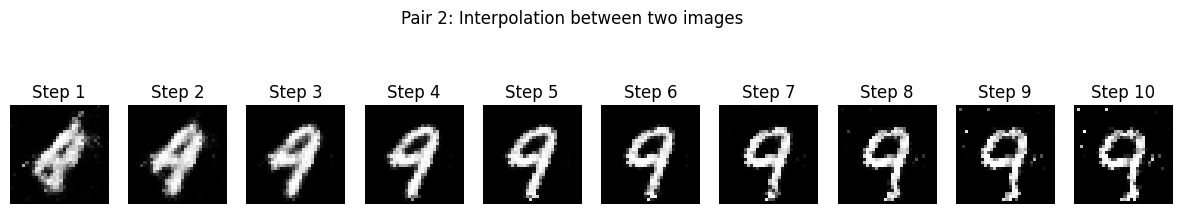

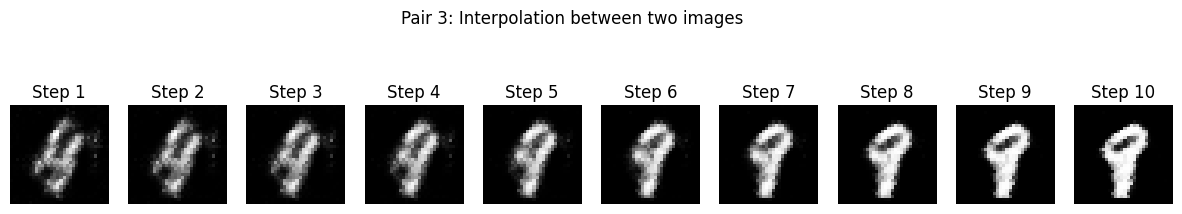

In [10]:
z_pairs = [(torch.randn(1, latent_dim), torch.randn(1, latent_dim)) for _ in range(3)]

num_steps = 10

for i, (z1, z2) in enumerate(z_pairs):
    interpolated_images = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = alpha * z1 + (1 - alpha) * z2
            generated_img = generator(z_interp)
            interpolated_images.append(generated_img.squeeze().cpu().numpy())

    interpolated_images = [(img + 1) / 2 for img in interpolated_images]

    plt.figure(figsize=(15, 3))
    for j, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, j+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Step {}'.format(j+1))
    plt.suptitle(f'Pair {i+1}: Interpolation between two images')
    plt.show()


# Some Analytical questions (5)

Q1) What would happen if you were to reduce the size of the dataset to 1/2 the number of images, and then train the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with the 1/2 the dataset
2. Generate images using this newly trained model
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

In [22]:
reduced_size = len(train_dataset) // 2
indices = torch.randperm(len(train_dataset))[:reduced_size]
reduced_dataset = torch.utils.data.Subset(train_dataset, indices)

reduced_train_loader = torch.utils.data.DataLoader(reduced_dataset, batch_size=4, shuffle=True)


In [23]:
epochs = 10
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for i, (imgs, _) in enumerate(reduced_train_loader):

        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        ############################
        # Train Discriminator
        ############################

        optimizer_d.zero_grad()


        real_imgs = imgs.type(torch.FloatTensor)
        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()

        ############################
        # Train Generator
        ############################

        optimizer_g.zero_grad()

        gen_imgs = generator(z)

        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, epochs, avg_d_loss, avg_g_loss)
    )


[Epoch 1/10] [D loss: 0.180449] [G loss: 5.046933]
[Epoch 2/10] [D loss: 0.471312] [G loss: 1.803773]
[Epoch 3/10] [D loss: 0.517785] [G loss: 1.426911]
[Epoch 4/10] [D loss: 0.506997] [G loss: 1.384429]
[Epoch 5/10] [D loss: 0.469559] [G loss: 1.494029]
[Epoch 6/10] [D loss: 0.461882] [G loss: 1.544053]
[Epoch 7/10] [D loss: 0.471192] [G loss: 1.509497]
[Epoch 8/10] [D loss: 0.473321] [G loss: 1.517001]
[Epoch 9/10] [D loss: 0.472730] [G loss: 1.511261]
[Epoch 10/10] [D loss: 0.465386] [G loss: 1.559329]


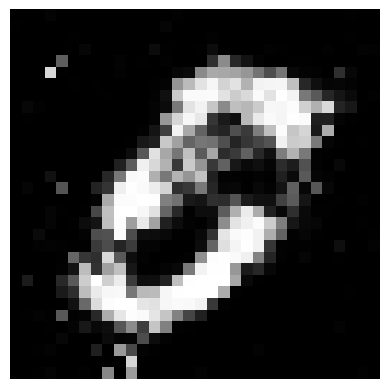

In [26]:
generator.eval()

z = torch.randn(1, latent_dim)

with torch.no_grad():
    generated_img = generator(z)

generated_img_np = generated_img.squeeze().cpu().numpy()

generated_img_np = (generated_img_np + 1) / 2

plt.imshow(generated_img_np, cmap='gray')
plt.axis('off')
plt.show()


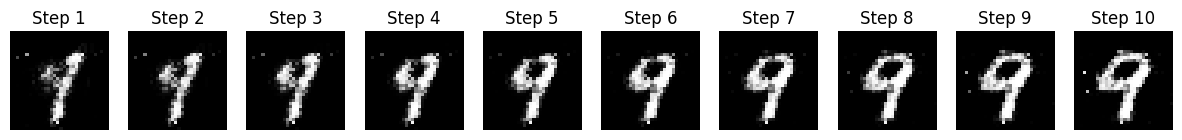

In [27]:
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

num_steps = 10

interpolated_images = []
with torch.no_grad():
    for alpha in np.linspace(0, 1, num_steps):
        z_interp = alpha * z1 + (1 - alpha) * z2
        generated_img = generator(z_interp)
        interpolated_images.append(generated_img.squeeze().cpu().numpy())

interpolated_images = [(img + 1) / 2 for img in interpolated_images]

plt.figure(figsize=(15, 3))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Step {}'.format(i+1))
plt.show()


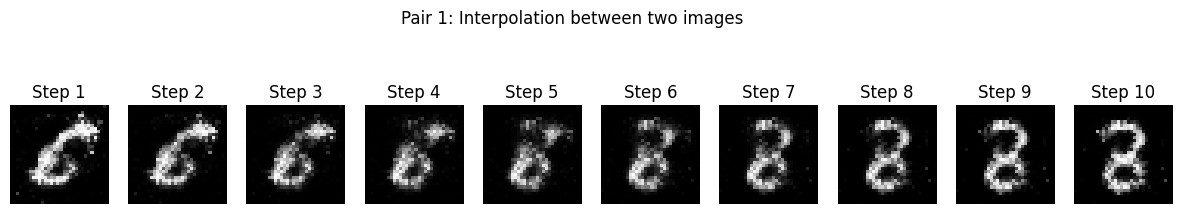

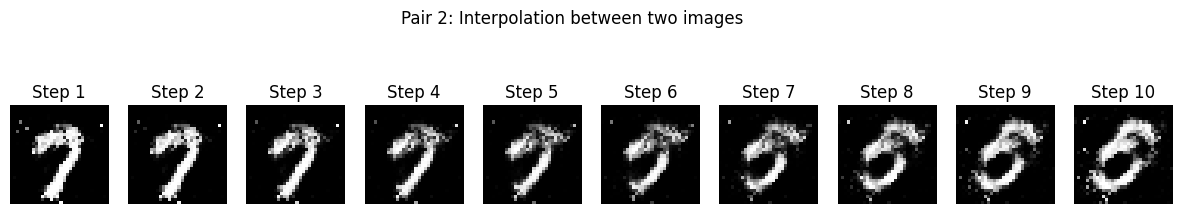

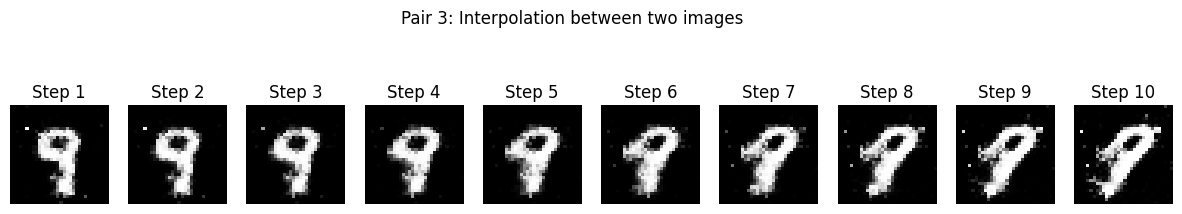

In [28]:
z_pairs = [(torch.randn(1, latent_dim), torch.randn(1, latent_dim)) for _ in range(3)]

num_steps = 10

for i, (z1, z2) in enumerate(z_pairs):
    interpolated_images = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = alpha * z1 + (1 - alpha) * z2
            generated_img = generator(z_interp)
            interpolated_images.append(generated_img.squeeze().cpu().numpy())

    interpolated_images = [(img + 1) / 2 for img in interpolated_images]

    plt.figure(figsize=(15, 3))
    for j, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, j+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Step {}'.format(j+1))
    plt.suptitle(f'Pair {i+1}: Interpolation between two images')
    plt.show()


In [ ]:
#Explanation: The images are somewhat similar to the images generated when we trained the model on the whole dataset. The interpolation is clearly differentiable meaning that we can easily see number X changing to number Y from the images.

Ans here:

Q2) What would happen if you were to change the loss function of the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with a different loss function, this could be any other loss function, it could be any of your choosing.
2. Generate images using this newly trained model.
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

Ans here:

In [33]:
criterion = nn.MSELoss()



In [34]:
epochs = 10
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for i, (imgs, _) in enumerate(reduced_train_loader):

        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        ############################
        # Train Discriminator
        ############################

        optimizer_d.zero_grad()

        real_imgs = imgs.type(torch.FloatTensor)
        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()

        ############################
        # Train Generator
        ############################

        optimizer_g.zero_grad()

        gen_imgs = generator(z)

        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, epochs, avg_d_loss, avg_g_loss)
    )


[Epoch 1/10] [D loss: 0.088726] [G loss: 0.763143]
[Epoch 2/10] [D loss: 0.158800] [G loss: 0.581900]
[Epoch 3/10] [D loss: 0.167373] [G loss: 0.542710]
[Epoch 4/10] [D loss: 0.165507] [G loss: 0.530469]
[Epoch 5/10] [D loss: 0.156365] [G loss: 0.545220]
[Epoch 6/10] [D loss: 0.156798] [G loss: 0.542657]
[Epoch 7/10] [D loss: 0.160009] [G loss: 0.536082]
[Epoch 8/10] [D loss: 0.161081] [G loss: 0.530173]
[Epoch 9/10] [D loss: 0.160472] [G loss: 0.532879]
[Epoch 10/10] [D loss: 0.160284] [G loss: 0.530520]


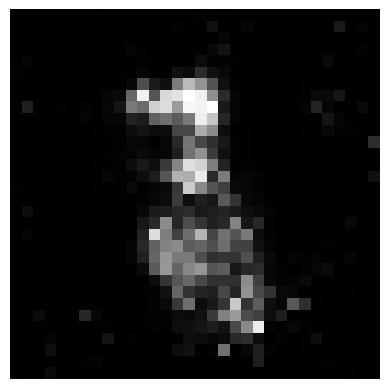

In [35]:
generator.eval()

z = torch.randn(1, latent_dim)

with torch.no_grad():
    generated_img = generator(z)

generated_img_np = generated_img.squeeze().cpu().numpy()

generated_img_np = (generated_img_np + 1) / 2

plt.imshow(generated_img_np, cmap='gray')
plt.axis('off')
plt.show()


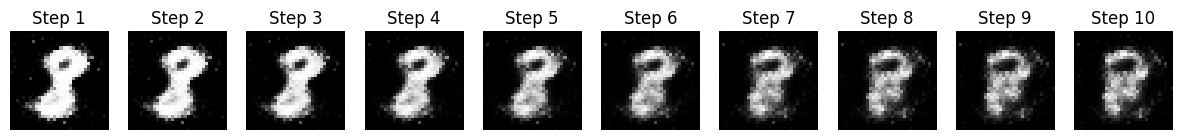

In [36]:
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

num_steps = 10

interpolated_images = []
with torch.no_grad():
    for alpha in np.linspace(0, 1, num_steps):
        z_interp = alpha * z1 + (1 - alpha) * z2
        generated_img = generator(z_interp)
        interpolated_images.append(generated_img.squeeze().cpu().numpy())

interpolated_images = [(img + 1) / 2 for img in interpolated_images]

plt.figure(figsize=(15, 3))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Step {}'.format(i+1))
plt.show()


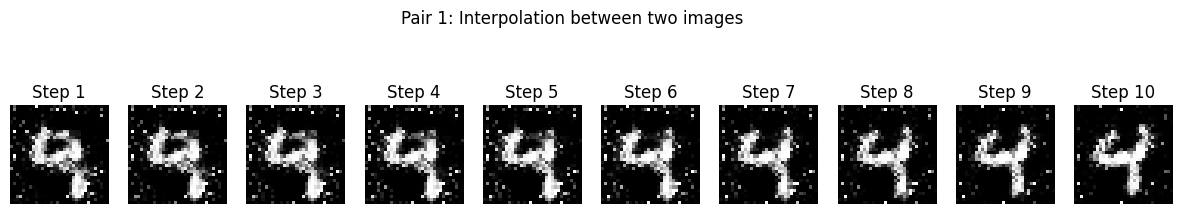

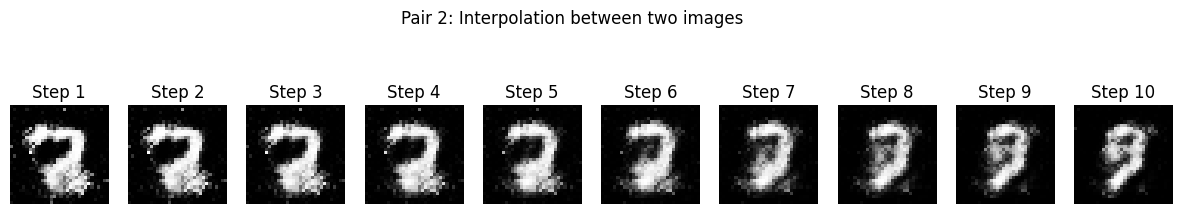

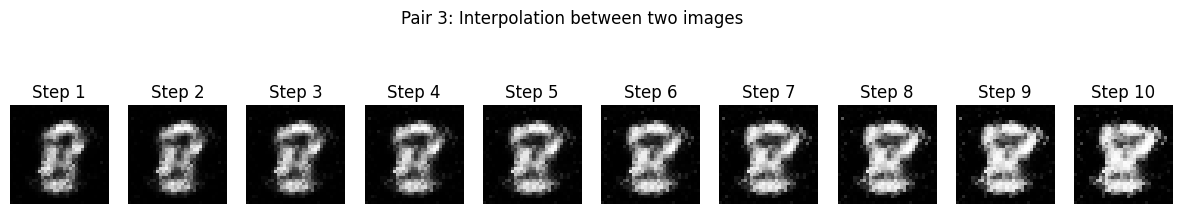

In [37]:
z_pairs = [(torch.randn(1, latent_dim), torch.randn(1, latent_dim)) for _ in range(3)]

num_steps = 10

for i, (z1, z2) in enumerate(z_pairs):
    interpolated_images = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = alpha * z1 + (1 - alpha) * z2
            generated_img = generator(z_interp)
            interpolated_images.append(generated_img.squeeze().cpu().numpy())

    interpolated_images = [(img + 1) / 2 for img in interpolated_images]

    plt.figure(figsize=(15, 3))
    for j, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, j+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Step {}'.format(j+1))
    plt.suptitle(f'Pair {i+1}: Interpolation between two images')
    plt.show()


In [ ]:
#Explanation: The images generated are different from the images generated when we used BCE Loss. The generator loss is significantly lower than when we used BCE loss but the images generated are not as clear and the process of interpolation is harder to see in these images. This might be due to the fact that MSE Loss measures the squared difference between the target and predicted values. In the context of GANs, this means it focuses on reducing the pixel-wise variance between generated and real images. While this can lead to lower overall loss values (as the model minimizes these variances), it doesn't necessarily prioritize the clarity or distinct features of the images. The generator might end up producing images that, on average, minimize variance but lack sharp details or clear interpolations between points in the latent space.